In [13]:
import tensorflow as tf
from tensorflow import keras
from collections import deque
import random
import matplotlib.pyplot as plt
import os
import numpy as np
import time

# F-model

In [14]:
class layer_initializer(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = keras.layers.Conv2D(
            filters=64,
            activation=tf.nn.relu,
            kernel_size=[5, 5],
            padding="same",
             kernel_initializer = 'glorot_uniform'
        )
        self.pool1 = keras.layers.MaxPool2D(
            pool_size=[2, 2],
            strides=2
        )
        self.conv2 = keras.layers.Conv2D(
            filters=64,
            activation=tf.nn.relu,
            kernel_size=[5, 5],
            padding="same",
             kernel_initializer = 'glorot_uniform'
        )
        self.pool2 = keras.layers.MaxPool2D(
            pool_size=[2, 2],
            strides=2
        )
        self.conv3 = keras.layers.Conv2D(
            filters=64,
            activation=tf.nn.relu,
            kernel_size=[5, 5],
            padding="same",
            kernel_initializer='glorot_uniform'
        )
        self.pool3 = keras.layers.MaxPool2D(
            pool_size=[2, 2],
            strides=2
        )
        self.fc1 = keras.layers.Dense(
            units=128,
            activation=tf.nn.relu,
             kernel_initializer = 'glorot_uniform'
        )
        self.fc2 = keras.layers.Dense(
            units=64,
            activation=tf.nn.relu,
            kernel_initializer='glorot_uniform'
        )

        self.fc3 = keras.layers.Dense(
            units=1,
             kernel_initializer = 'glorot_uniform'
        )
        self.survival_fc= keras.layers.Dense(
            units=4800,
             kernel_initializer = 'glorot_uniform'
        )
    def call(self, Input,layer_limit):
        Input = np.expand_dims(Input,axis=0)
        Input = np.expand_dims(Input, axis=3)
        x = self.conv1(Input)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        #x=self.conv3(x)
        #x=self.pool3(x)
        x = tf.reshape(x, shape=(1,-1))
        try:
            x = self.fc1(x)
        except:
            x=self.survival_fc(x)
            x=self.fc1(x)
        x= self.fc2(x)
        self.x = self.fc3(x)
        #self.x=tf.maximum(x,1)
        #self.x=tf.minimum( self.x,layer_limit)
        return self.x
    def learn(self,real_layer):
        self.loss=tf.reduce_mean(tf.keras.losses.MSE( self.x,real_layer))
        return  self.loss
    def Train(self,iters,Input,real_label,layer_limit):
        iter_=0
        done=0
        loss_record=[]
        acc=[]
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
        with tf.GradientTape(persistent=True) as tape:
            for i in range(iters):
                x=self(Input,layer_limit)
                loss = tf.reduce_mean(tf.keras.losses.MSE(x, real_label))
                grads=tape.gradient(loss,self.variables)
                optimizer.apply_gradients(grads_and_vars=zip(grads,self.variables))
                loss_record.append(loss.numpy())
                acc.append(x[0][0]/real_label)
        return loss_record,acc

# Environment
## Create ANN， and return the train loss value.

In [15]:
class ENV(tf.keras.Model):

    def __init__(self,train,test,layers):
        super().__init__()
        self.train=train
        self.test=test
        output_dim=1
        self.add_sublayer=[]
        self.drop = tf.keras.layers.Dropout(0.5)
        #self.drop= tf.keras.layers.Dropout(rate=0.5)
        for seq in range(int(layers)):
            self.add_sublayer.append(keras.layers.Dense(units=500,activation=tf.nn.relu,\
                                     name="layer {}".format(seq+2),kernel_initializer='glorot_uniform',\
                                                        bias_initializer="zero"))
            if seq !=0&seq<layers-1:
                self.add_sublayer.append(self.drop)
        self.add_sublayer.append(keras.layers.Dense(units= output_dim,name="layer last"))

    def call(self,key):
        prediction=self.train
        for i in  self.add_sublayer:
            prediction=i(prediction)
        self.prediction=prediction
        return self.prediction

    def Train(self,turns):
        loss_record=[]
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
        with tf.GradientTape(persistent=True) as tape:
            for i in range(turns):
                x = self(self.train)
                loss=tf.reduce_mean(tf.keras.losses.MSE(y_pred=x,y_true=self.test))
                #print(loss)
                #loss_record.append(loss)
                grads=tape.gradient(loss,self.variables)
                optimizer.apply_gradients(grads_and_vars=zip(grads,self.variables))
                if loss<0.05:
                    return loss_record
            return loss_record


    def learn(self):
        self.loss = tf.reduce_mean(tf.keras.losses.MSE(self.prediction, self.test))
        self.accuracy = tf.reduce_mean(self.prediction / self.test)
        return self.loss.numpy(), self.accuracy.numpy()


# Value function Q

In [16]:
class critic(keras.Model):
    def __init__(self):
        super().__init__()
        self.fc1 = keras.layers.Dense(
            units=10,
            activation=tf.nn.relu,
            kernel_initializer='glorot_uniform'
        )
        self.fc2 = keras.layers.Dense(
            units=5,
            activation=tf.nn.relu,
            kernel_initializer='glorot_uniform'
        )

        self.fc3 = keras.layers.Dense(
            units=2,
            kernel_initializer='glorot_uniform',
        )

    def call(self, Input):
        x = self.fc1(Input)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

    def train(self, batch_size, rewards, nextstates, states, gamma, actor):
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        error_record = []
        with tf.GradientTape(persistent=True) as tape:
            for i in range(len(states)):
                td_error = self(nextstates[i]) * gamma + rewards[i] - self(states[i])
                td_error = -tf.matmul(tf.math.log(actor(states[i])+1e-4), tf.transpose(td_error))
                error_record.append(td_error)
                error = 0.5 * tf.square(td_error)
                error_record.append(error)
                grads = tape.gradient(error, self.variables)
                optimizer.apply_gradients(grads_and_vars=zip(grads, self.variables))

        return tf.reduce_mean(error_record)


# Policy function $\pi$

In [28]:
class actor(tf.keras.Model):
    def __init__(self):
        super(actor,self).__init__()
        self.fc1 = keras.layers.Dense(
            units=10,
            activation=tf.nn.relu,
            kernel_initializer='glorot_uniform'
        )
        self.fc2 = keras.layers.Dense(
            units=5,
            activation=tf.nn.relu,
            kernel_initializer='glorot_uniform'
        )

        self.fc3 = keras.layers.Dense(
            units=2,
            kernel_initializer='glorot_uniform',
            activation=tf.nn.softmax
        )

    def call(self, Input):

        x = self.fc1(Input)
        x = self.fc2(x)
        self.x = self.fc3(x)
        # self.x=tf.maximum(x,1)
        # self.x=tf.minimum( self.x,layer_limit)
        return self.x

    def Train(self, iters, states, nextstates, rewards, gamma, critics):
        policy_record = []
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        with tf.GradientTape(persistent=True) as tape:
            for j in range(iters):
                for i in range(len(states)):
                    x = self(states[i])
                    TDE = critics(nextstates[i]) * gamma + rewards[i] - critics(states[i])
                    policy_error = -tf.matmul(tf.math.log(x+1e-4), tf.transpose(TDE))
                    policy_record.append(policy_error)
                    grads = tape.gradient(policy_error, self.variables)
                    optimizer.apply_gradients(grads_and_vars=zip(grads, self.variables))

            return tf.reduce_mean(policy_record)

In [5]:
#Config GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

#Upload and normoalize the dataset
def normalization(data):
    return (data-data.mean())/data.std()
(train_x,train_y),(test_x,_)=tf.keras.datasets.boston_housing.load_data()
train=normalization(train_x[:100]).astype("float32")
test=train_y[:100].astype("float32")

#parameters
layer_limit=15
eposide=70
iteration=20
batch_size=40
e_greedy=0.8
layer_init = 5.0
optimal_loss=1000000
#initialize the actor and critic
actor = actor()
critic = critic()
queue = deque(maxlen=2000)
# ENV
env = ENV(train, test, layer_init)
env.Train(60)
loss = env.learn()
#record
layer_all = []
td_error_record = []
policy_error_record = []
loss_r=[]
total_loss=[]
start=time.time()
for i in range(eposide):
    whole_trend = []
    layer_r = []
    layer_init = 5.0
    env = ENV(train, test, layer_init)
    env.Train(60)
    loss = env.learn()
    for j in range(iteration):
        In = np.array([[loss[0],layer_init*10]]).reshape(1,-1)
        if np.random.randn() > e_greedy:
            action = np.random.choice([0, 1])
        else:
            actions = actor(In)
            action = np.argmax(actions)
        if action == 1:
            layer_next = layer_init + 1
        if action == 0:
            layer_next = layer_init - 1
        if layer_next > layer_limit:
            layer_next = layer_limit
        if layer_next<=0:
            layer_next=1
        layer_r.append(layer_next)
        loss_r.append(loss)
        env = ENV(train, test, layer_next)
        env.Train(60)

        next_loss = env.learn()
        if next_loss[0]<optimal_loss:
            optimal_loss=next_loss[0]
        if next_loss [0]> loss[0]:
            reward = (-next_loss[0] + loss[0]) / next_loss[0] * 10+(optimal_loss-next_loss)/optimal_loss*100
        if layer_next == 0:
            layer_next = 1
        if next_loss[0] < loss[0]:
            reward = (-next_loss[0] + loss[0]) / loss[0] * 10

        queue.append([loss, next_loss, reward, action,layer_init,layer_next])
        layer_init = layer_next
        loss = next_loss
        print("loss:{}----layer:{}----acc:{}-----Iteration:{}----eposide:{}".format(next_loss[0],layer_init,\
                                                                                       next_loss[1],j+1,i+1))
    total_loss.append(loss_r)
    layer_all.append(layer_r)

    print("%%%%%%%%%%%%%%%%%%%%%eposide:{}%%%%%%%%%%%%%%%%%%%%%%%%".format(i+1), next_loss[0], layer_init)

    if len(queue) > batch_size:
        print("updating")
        losses, next_losses, rewards, actions,layer_inits ,layer_nexts= zip(*random.sample(queue, batch_size))
        states = []
        next_states = []
        for i in range(len(losses)):
            states.append(np.array([[losses[i][0],layer_inits[i]*10]]).reshape(1, -1))
            next_states.append(np.array([[next_losses[i][0],layer_nexts[i]*10]]).reshape(1, -1))
        del (losses)
        del (next_losses)
        td_error = critic.train(50, rewards, nextstates=next_states, states=states, gamma=0.9, actor=actor)
        policy_error = actor.Train(50, states, next_states, rewards, gamma=0.9, critics=critic)
        del (rewards)
        queue.clear()
        policy_error_record.append(policy_error.numpy())
        td_error_record.append(td_error.numpy())
print("time cost:{}".format(time.time()-start))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

loss:92.7578353881836----layer:4.0----acc:1.1634820699691772-----Iteration:1----eposide:1
loss:93.64209747314453----layer:3.0----acc:1.153928279876709-----Iteration:2----eposide:1
loss:95.0810317993164----layer:2.0----acc:1.1831613779067993-----Iteration:3----eposide:1
loss:119.03219604492188----layer:1.0----acc:0.9219372868537903-----Iteration:4----eposide:1
loss:125.58695983886719----layer:1----acc:0.8825675845146179-----Iteration:5----eposide:1
loss:147.4912872314453----layer:1----acc:0.7871421575546

loss:92.81353759765625----layer:6.0----acc:1.153616189956665-----Iteration:1----eposide:4
loss:92.9248046875----layer:5.0----acc:1.2175720930099487-----Iteration:2----eposide:4
loss:92.81942749023438----layer:6.0----acc:1.1422247886657715-----Iteration:3----eposide:4
loss:92.63416290283203----layer:5.0----acc:1.2092220783233643-----Iteration:4----eposide:4
loss:92.96749114990234----layer:6.0----acc:1.1555815935134888-----Iteration:5----eposide:4
loss:92.81266784667969----layer:5.0----acc:1.2171670198440552-----Iteration:6----eposide:4
loss:93.21197509765625----layer:6.0----acc:1.141669750213623-----Iteration:7----eposide:4
loss:92.9825210571289----layer:5.0----acc:1.2190486192703247-----Iteration:8----eposide:4
loss:92.34555053710938----layer:6.0----acc:1.1986535787582397-----Iteration:9----eposide:4
loss:93.02587127685547----layer:5.0----acc:1.2195172309875488-----Iteration:10----eposide:4
loss:92.42304992675781----layer:6.0----acc:1.199941635131836-----Iteration:11----eposide:4
loss:

loss:92.39785766601562----layer:7.0----acc:1.1802934408187866-----Iteration:8----eposide:8
loss:92.70848846435547----layer:6.0----acc:1.1591285467147827-----Iteration:9----eposide:8
loss:92.82649230957031----layer:7.0----acc:1.1549458503723145-----Iteration:10----eposide:8
loss:92.67556762695312----layer:6.0----acc:1.171502709388733-----Iteration:11----eposide:8
loss:93.2321548461914----layer:7.0----acc:1.1353484392166138-----Iteration:12----eposide:8
loss:92.87873840332031----layer:6.0----acc:1.1479989290237427-----Iteration:13----eposide:8
loss:92.32966613769531----layer:7.0----acc:1.1701905727386475-----Iteration:14----eposide:8
loss:92.51973724365234----layer:6.0----acc:1.219098448753357-----Iteration:15----eposide:8
loss:92.53330993652344----layer:5.0----acc:1.1669986248016357-----Iteration:16----eposide:8
loss:92.53582000732422----layer:6.0----acc:1.192838430404663-----Iteration:17----eposide:8
loss:93.04914855957031----layer:7.0----acc:1.1429715156555176-----Iteration:18----epos

loss:99.36227416992188----layer:13.0----acc:1.0415949821472168-----Iteration:14----eposide:12
loss:93.3694076538086----layer:14.0----acc:1.1487548351287842-----Iteration:15----eposide:12
loss:92.19509887695312----layer:13.0----acc:1.154665231704712-----Iteration:16----eposide:12
loss:91.90348815917969----layer:12.0----acc:1.2012982368469238-----Iteration:17----eposide:12
loss:92.12413024902344----layer:13.0----acc:1.1574428081512451-----Iteration:18----eposide:12
loss:91.81197357177734----layer:12.0----acc:1.1729793548583984-----Iteration:19----eposide:12
loss:96.42533111572266----layer:13.0----acc:1.0830258131027222-----Iteration:20----eposide:12
%%%%%%%%%%%%%%%%%%%%%eposide:12%%%%%%%%%%%%%%%%%%%%%%%% 96.42533 13.0
updating
loss:93.05963897705078----layer:4.0----acc:1.160890817642212-----Iteration:1----eposide:13
loss:92.82858276367188----layer:5.0----acc:1.20668363571167-----Iteration:2----eposide:13
loss:93.20641326904297----layer:6.0----acc:1.1407865285873413-----Iteration:3----epo

loss:95.08080291748047----layer:15----acc:1.102809190750122-----Iteration:20----eposide:16
%%%%%%%%%%%%%%%%%%%%%eposide:16%%%%%%%%%%%%%%%%%%%%%%%% 95.0808 15
loss:92.82780456542969----layer:6.0----acc:1.2151658535003662-----Iteration:1----eposide:17
loss:93.1509780883789----layer:7.0----acc:1.137435793876648-----Iteration:2----eposide:17
loss:92.94033813476562----layer:6.0----acc:1.1530218124389648-----Iteration:3----eposide:17
loss:92.3383560180664----layer:7.0----acc:1.1985334157943726-----Iteration:4----eposide:17
loss:92.91761779785156----layer:8.0----acc:1.145501732826233-----Iteration:5----eposide:17
loss:92.37936401367188----layer:9.0----acc:1.2115283012390137-----Iteration:6----eposide:17
loss:93.4563217163086----layer:10.0----acc:1.2300422191619873-----Iteration:7----eposide:17
loss:92.48690795898438----layer:11.0----acc:1.1508910655975342-----Iteration:8----eposide:17
loss:92.90400695800781----layer:12.0----acc:1.228034496307373-----Iteration:9----eposide:17
loss:94.117462158

loss:92.35218048095703----layer:9.0----acc:1.1580166816711426-----Iteration:6----eposide:21
loss:95.26042938232422----layer:10.0----acc:1.107774019241333-----Iteration:7----eposide:21
loss:91.9050521850586----layer:11.0----acc:1.1948001384735107-----Iteration:8----eposide:21
loss:93.85857391357422----layer:12.0----acc:1.1360372304916382-----Iteration:9----eposide:21
loss:95.83746337890625----layer:13.0----acc:1.2788500785827637-----Iteration:10----eposide:21
loss:92.69688415527344----layer:14.0----acc:1.1474971771240234-----Iteration:11----eposide:21
loss:100.90119171142578----layer:15.0----acc:1.030377745628357-----Iteration:12----eposide:21
loss:96.3356704711914----layer:15----acc:1.2877979278564453-----Iteration:13----eposide:21
loss:93.07681274414062----layer:15----acc:1.1522043943405151-----Iteration:14----eposide:21
loss:94.16678619384766----layer:14----acc:1.108917236328125-----Iteration:15----eposide:21
loss:91.77761840820312----layer:13----acc:1.1707745790481567-----Iteration:

loss:92.7868423461914----layer:15----acc:1.1391559839248657-----Iteration:12----eposide:25
loss:92.53910064697266----layer:15----acc:1.2104624509811401-----Iteration:13----eposide:25
loss:93.2967300415039----layer:15----acc:1.2409379482269287-----Iteration:14----eposide:25
loss:92.66368103027344----layer:15----acc:1.1573008298873901-----Iteration:15----eposide:25
loss:93.69573974609375----layer:15----acc:1.1167490482330322-----Iteration:16----eposide:25
loss:92.60282135009766----layer:15----acc:1.1448019742965698-----Iteration:17----eposide:25
loss:93.35783386230469----layer:15----acc:1.1252658367156982-----Iteration:18----eposide:25
loss:98.20922088623047----layer:15----acc:1.3075251579284668-----Iteration:19----eposide:25
loss:94.65987396240234----layer:15----acc:1.1082955598831177-----Iteration:20----eposide:25
%%%%%%%%%%%%%%%%%%%%%eposide:25%%%%%%%%%%%%%%%%%%%%%%%% 94.659874 15
loss:92.54586029052734----layer:6.0----acc:1.209625005722046-----Iteration:1----eposide:26
loss:93.348953

loss:92.82379150390625----layer:15----acc:1.2308837175369263-----Iteration:18----eposide:29
loss:91.86430358886719----layer:14----acc:1.206315040588379-----Iteration:19----eposide:29
loss:92.02950286865234----layer:15----acc:1.1915466785430908-----Iteration:20----eposide:29
%%%%%%%%%%%%%%%%%%%%%eposide:29%%%%%%%%%%%%%%%%%%%%%%%% 92.0295 15
loss:92.22142791748047----layer:6.0----acc:1.1955113410949707-----Iteration:1----eposide:30
loss:93.00377655029297----layer:7.0----acc:1.2048989534378052-----Iteration:2----eposide:30
loss:92.52684783935547----layer:6.0----acc:1.1943159103393555-----Iteration:3----eposide:30
loss:92.90064239501953----layer:7.0----acc:1.2250845432281494-----Iteration:4----eposide:30
loss:92.0708999633789----layer:8.0----acc:1.1681936979293823-----Iteration:5----eposide:30
loss:92.038818359375----layer:9.0----acc:1.1744987964630127-----Iteration:6----eposide:30
loss:92.15191650390625----layer:10.0----acc:1.1588339805603027-----Iteration:7----eposide:30
loss:94.94995880

loss:93.94652557373047----layer:9.0----acc:1.1303918361663818-----Iteration:4----eposide:34
loss:95.595947265625----layer:10.0----acc:1.2634471654891968-----Iteration:5----eposide:34
loss:97.18645477294922----layer:11.0----acc:1.0763635635375977-----Iteration:6----eposide:34
loss:91.93962860107422----layer:12.0----acc:1.200730323791504-----Iteration:7----eposide:34
loss:91.78636932373047----layer:13.0----acc:1.1723066568374634-----Iteration:8----eposide:34
loss:92.74397277832031----layer:14.0----acc:1.1694183349609375-----Iteration:9----eposide:34
loss:93.37413024902344----layer:15.0----acc:1.1278890371322632-----Iteration:10----eposide:34
loss:92.76154327392578----layer:15----acc:1.148291826248169-----Iteration:11----eposide:34
loss:91.78132629394531----layer:15----acc:1.2026762962341309-----Iteration:12----eposide:34
loss:93.73534393310547----layer:15----acc:1.1229511499404907-----Iteration:13----eposide:34
loss:92.6640396118164----layer:15----acc:1.1399662494659424-----Iteration:14-

loss:92.85090637207031----layer:13.0----acc:1.1414895057678223-----Iteration:10----eposide:38
loss:91.73908996582031----layer:12.0----acc:1.1747808456420898-----Iteration:11----eposide:38
loss:92.00659942626953----layer:13.0----acc:1.1691393852233887-----Iteration:12----eposide:38
loss:92.03822326660156----layer:14.0----acc:1.1961419582366943-----Iteration:13----eposide:38
loss:92.47325134277344----layer:15.0----acc:1.1579267978668213-----Iteration:14----eposide:38
loss:91.92524719238281----layer:15----acc:1.1884429454803467-----Iteration:15----eposide:38
loss:91.88125610351562----layer:15----acc:1.1978371143341064-----Iteration:16----eposide:38
loss:91.8672103881836----layer:15----acc:1.1950145959854126-----Iteration:17----eposide:38
loss:92.44300842285156----layer:15----acc:1.219794750213623-----Iteration:18----eposide:38
loss:92.11559295654297----layer:15----acc:1.2082918882369995-----Iteration:19----eposide:38
loss:96.00860595703125----layer:15----acc:1.0837986469268799-----Iterati

loss:92.69956970214844----layer:15----acc:1.1546088457107544-----Iteration:16----eposide:42
loss:91.69326782226562----layer:15----acc:1.1930168867111206-----Iteration:17----eposide:42
loss:93.29681396484375----layer:15----acc:1.2407976388931274-----Iteration:18----eposide:42
loss:95.57634735107422----layer:15----acc:1.08713698387146-----Iteration:19----eposide:42
loss:94.57220458984375----layer:15----acc:1.102311372756958-----Iteration:20----eposide:42
%%%%%%%%%%%%%%%%%%%%%eposide:42%%%%%%%%%%%%%%%%%%%%%%%% 94.572205 15
updating
loss:92.70713806152344----layer:6.0----acc:1.2179988622665405-----Iteration:1----eposide:43
loss:92.33605194091797----layer:7.0----acc:1.199613332748413-----Iteration:2----eposide:43
loss:92.30245971679688----layer:8.0----acc:1.1769740581512451-----Iteration:3----eposide:43
loss:94.08731079101562----layer:9.0----acc:1.2278062105178833-----Iteration:4----eposide:43
loss:94.16490173339844----layer:10.0----acc:1.1209102869033813-----Iteration:5----eposide:43
loss:

loss:92.63597869873047----layer:7.0----acc:1.183423638343811-----Iteration:2----eposide:47
loss:92.67247772216797----layer:6.0----acc:1.1558382511138916-----Iteration:3----eposide:47
loss:93.00019836425781----layer:5.0----acc:1.2206213474273682-----Iteration:4----eposide:47
loss:92.32865905761719----layer:6.0----acc:1.1848129034042358-----Iteration:5----eposide:47
loss:93.31571197509766----layer:7.0----acc:1.1323351860046387-----Iteration:6----eposide:47
loss:93.39628601074219----layer:8.0----acc:1.13273286819458-----Iteration:7----eposide:47
loss:92.66272735595703----layer:9.0----acc:1.1698126792907715-----Iteration:8----eposide:47
loss:92.24060821533203----layer:10.0----acc:1.1716548204421997-----Iteration:9----eposide:47
loss:93.16825866699219----layer:9.0----acc:1.136110544204712-----Iteration:10----eposide:47
loss:96.98025512695312----layer:10.0----acc:1.0781413316726685-----Iteration:11----eposide:47
loss:92.56149291992188----layer:11.0----acc:1.1956294775009155-----Iteration:12-

loss:94.59305572509766----layer:10.0----acc:1.109694480895996-----Iteration:9----eposide:51
loss:95.0380630493164----layer:11.0----acc:1.1143896579742432-----Iteration:10----eposide:51
loss:97.83403015136719----layer:12.0----acc:1.0621845722198486-----Iteration:11----eposide:51
loss:94.75630950927734----layer:13.0----acc:1.106919288635254-----Iteration:12----eposide:51
loss:92.41883087158203----layer:14.0----acc:1.1528743505477905-----Iteration:13----eposide:51
loss:93.63667297363281----layer:15.0----acc:1.1205424070358276-----Iteration:14----eposide:51
loss:92.63105773925781----layer:15----acc:1.1458419561386108-----Iteration:15----eposide:51
loss:103.50557708740234----layer:15----acc:1.0072853565216064-----Iteration:16----eposide:51
loss:96.48839569091797----layer:15----acc:1.2886401414871216-----Iteration:17----eposide:51
loss:94.12346649169922----layer:15----acc:1.1128036975860596-----Iteration:18----eposide:51
loss:99.4343490600586----layer:15----acc:1.3248785734176636-----Iterati

loss:92.49188232421875----layer:14.0----acc:1.1707264184951782-----Iteration:15----eposide:55
loss:94.23072052001953----layer:15.0----acc:1.1083104610443115-----Iteration:16----eposide:55
loss:91.70601654052734----layer:15----acc:1.1724019050598145-----Iteration:17----eposide:55
loss:91.70646667480469----layer:15----acc:1.173813819885254-----Iteration:18----eposide:55
loss:99.68829345703125----layer:15----acc:1.33054518699646-----Iteration:19----eposide:55
loss:93.8549575805664----layer:15----acc:1.118009328842163-----Iteration:20----eposide:55
%%%%%%%%%%%%%%%%%%%%%eposide:55%%%%%%%%%%%%%%%%%%%%%%%% 93.85496 15
loss:92.72767639160156----layer:6.0----acc:1.2176774740219116-----Iteration:1----eposide:56
loss:92.36532592773438----layer:7.0----acc:1.1587316989898682-----Iteration:2----eposide:56
loss:94.40177917480469----layer:8.0----acc:1.247864007949829-----Iteration:3----eposide:56
loss:92.6623764038086----layer:9.0----acc:1.1530078649520874-----Iteration:4----eposide:56
loss:92.0638504

loss:92.56707763671875----layer:6.0----acc:1.2026877403259277-----Iteration:1----eposide:60
loss:93.11041259765625----layer:7.0----acc:1.223929524421692-----Iteration:2----eposide:60
loss:92.97244262695312----layer:8.0----acc:1.1436394453048706-----Iteration:3----eposide:60
loss:93.61065673828125----layer:9.0----acc:1.2266902923583984-----Iteration:4----eposide:60
loss:96.76019287109375----layer:10.0----acc:1.075441837310791-----Iteration:5----eposide:60
loss:92.15509033203125----layer:11.0----acc:1.1809484958648682-----Iteration:6----eposide:60
loss:92.49777221679688----layer:12.0----acc:1.224355697631836-----Iteration:7----eposide:60
loss:93.11306762695312----layer:13.0----acc:1.224815011024475-----Iteration:8----eposide:60
loss:93.41044616699219----layer:14.0----acc:1.1266677379608154-----Iteration:9----eposide:60
loss:93.47359466552734----layer:15.0----acc:1.1229045391082764-----Iteration:10----eposide:60
loss:91.72666931152344----layer:15----acc:1.20409095287323-----Iteration:11--

loss:92.97994232177734----layer:8.0----acc:1.2146064043045044-----Iteration:7----eposide:64
loss:92.27002716064453----layer:9.0----acc:1.1600205898284912-----Iteration:8----eposide:64
loss:96.77079772949219----layer:10.0----acc:1.0777223110198975-----Iteration:9----eposide:64
loss:92.81774139404297----layer:11.0----acc:1.2106428146362305-----Iteration:10----eposide:64
loss:91.94210815429688----layer:12.0----acc:1.201492428779602-----Iteration:11----eposide:64
loss:92.39026641845703----layer:13.0----acc:1.1563208103179932-----Iteration:12----eposide:64
loss:100.15147399902344----layer:14.0----acc:1.035475492477417-----Iteration:13----eposide:64
loss:94.90777587890625----layer:15.0----acc:1.0986477136611938-----Iteration:14----eposide:64
loss:101.33119201660156----layer:15----acc:1.0228888988494873-----Iteration:15----eposide:64
loss:93.65132904052734----layer:15----acc:1.116588830947876-----Iteration:16----eposide:64
loss:93.11384582519531----layer:15----acc:1.2291685342788696-----Itera

loss:92.1985092163086----layer:15----acc:1.1579278707504272-----Iteration:13----eposide:68
loss:92.43062591552734----layer:15----acc:1.15476393699646-----Iteration:14----eposide:68
loss:96.11917877197266----layer:15----acc:1.0791363716125488-----Iteration:15----eposide:68
loss:92.22982788085938----layer:14----acc:1.1832351684570312-----Iteration:16----eposide:68
loss:92.96955108642578----layer:15----acc:1.1356102228164673-----Iteration:17----eposide:68
loss:95.25457000732422----layer:15----acc:1.0905423164367676-----Iteration:18----eposide:68
loss:92.58406066894531----layer:14----acc:1.1666938066482544-----Iteration:19----eposide:68
loss:94.22711944580078----layer:15----acc:1.1074668169021606-----Iteration:20----eposide:68
%%%%%%%%%%%%%%%%%%%%%eposide:68%%%%%%%%%%%%%%%%%%%%%%%% 94.22712 15
loss:92.60916900634766----layer:6.0----acc:1.214942216873169-----Iteration:1----eposide:69
loss:92.97697448730469----layer:5.0----acc:1.2218023538589478-----Iteration:2----eposide:69
loss:92.84452819

In [19]:
np.save("loss_and_acc_all.npy",np.array(total_loss))
np.save("layer_all.npy",np.array(layer_all))

In [7]:
np.save("policy_error_record.npy",np.array(policy_error_record))
np.save("td_error_record.npy",np.array(td_error_record))

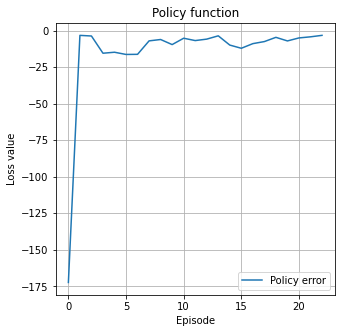

In [81]:
plt.figure(figsize=(5,5))
plt.grid()
plt.title("Policy function")
plt.plot(policy_error_record,label="Policy error")
plt.xlabel("Episode")
plt.ylabel("Loss value")
plt.legend()
plt.savefig("p_loss.jpg")
plt.show()

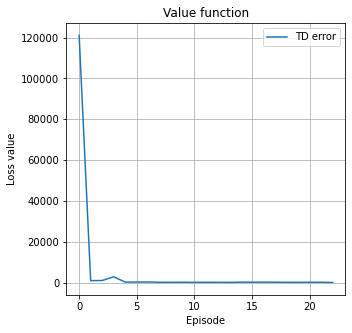

In [82]:
plt.figure(figsize=(5,5))
plt.grid()
plt.title("Value function")
plt.plot(td_error_record,label="TD error")
plt.xlabel("Episode")
plt.ylabel("Loss value")
plt.legend()
plt.savefig("td_loss.jpg")
plt.show()

In [24]:
total_loss=np.load("loss_and_acc_all.npy")
layer_all=np.load("layer_all.npy")

In [29]:
acc_all=[]
loss_all=[]
index=0
for per_r in total_loss[0]:
    Acc_r=[]
    Loss_r=[]
    for j in range(20):
        Acc_r.append(per_r[1])
        Loss_r.append(per_r[0])
    acc_all.append(Acc_r)
    loss_all.append(Loss_r)
np.save("acc_all.npy",np.array(acc_all))
np.save("loss_all.npy",np.array(loss_all))

In [77]:
acc_whole_trend=[]
loss_whole_trend=[]
for per_r in total_loss[0]:
    acc_whole_trend.append(per_r[1])
    loss_whole_trend.append(per_r[0])

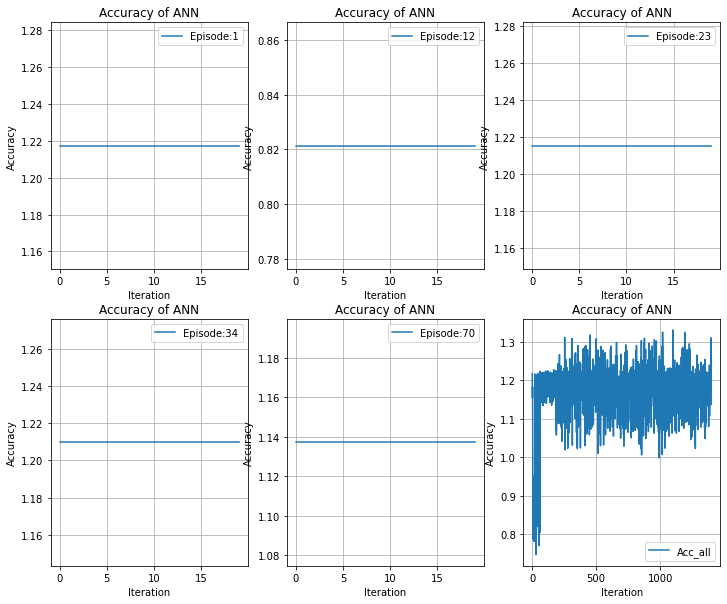

In [83]:
plt.figure(figsize=(12,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.grid()
    plt.title("Accuracy of ANN")
    if i==5:
        plt.plot(acc_whole_trend,label="Acc_all")
    elif i==4:
        plt.plot(acc_all[-1],label="Episode:{}".format(70))
    else:
        plt.plot(acc_all[i*11],label="Episode:{}".format(i*11+1))
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend()
plt.savefig("ANN_acc.jpg")

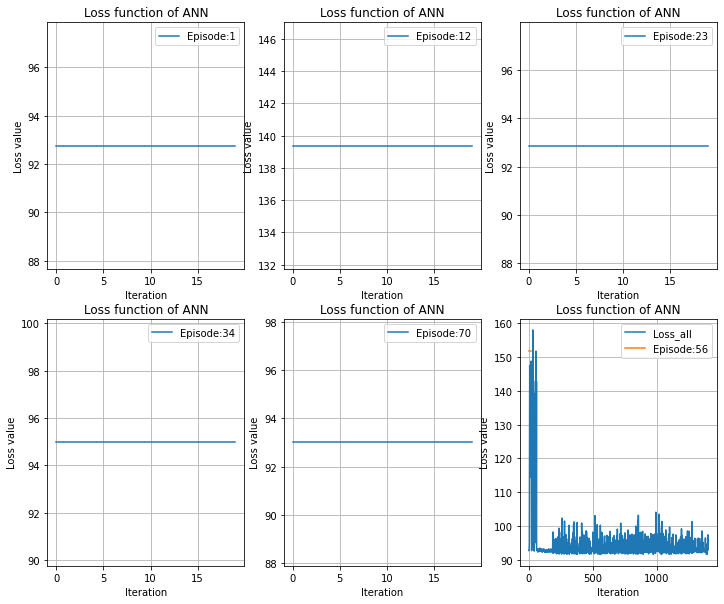

In [84]:
plt.figure(figsize=(12,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.grid()
    plt.title("Loss function of ANN")
    if i==5:
        plt.plot(loss_whole_trend,label="Loss_all")
    if i==4:
        plt.plot(loss_all[-1],label="Episode:{}".format(70))
    else:
        plt.plot(loss_all[i*11],label="Episode:{}".format(i*11+1))
    plt.xlabel("Iteration")
    plt.ylabel("Loss value")
    plt.legend()
plt.savefig("ANN_loss.jpg")

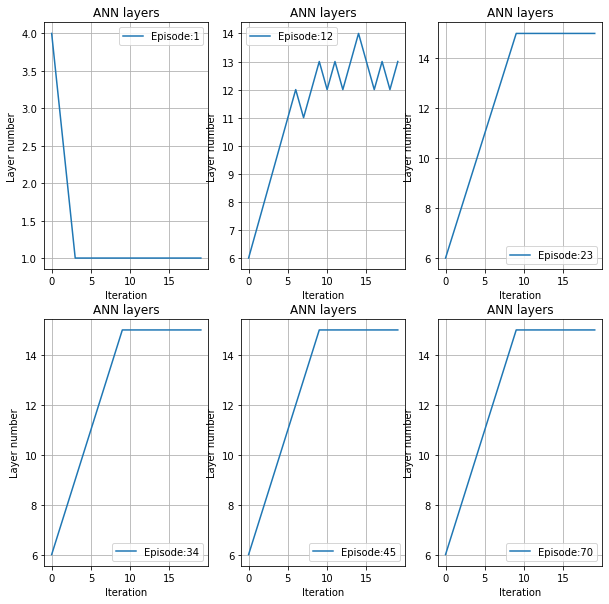

In [75]:
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.grid()
    plt.title("ANN layers")
    if i==5:
        plt.plot(layer_all[-1],label="Episode:{}".format(70))
    else:
        plt.plot(layer_all[i*11],label="Episode:{}".format(i*11+1))
    plt.xlabel("Iteration")
    plt.ylabel("Layer number")
    plt.legend()
plt.savefig("ANN_layers.jpg")

# Last stage
## Using the optimal number to train F-model.
## Using the two-staged model to train and prediction on the Boston Housing dataset.

In [53]:
def normalization(data):
    return (data-data.mean())/data.std()
(train_x,train_y),(test_x,test_y)=tf.keras.datasets.boston_housing.load_data()
train=normalization(train_x[:100]).astype("float32")
test=train_y[:100].astype("float32")
Val=train
Val_test=test

In [59]:
try:
    actor = actor()
except:
    print("actor has been initialized")
e_greedy=0.8
layer_limit=15.
iteration=20
layer_init=15.
env = ENV(Val,Val_test, layer_init)
env.Train(60)
loss = env.learn()
In = np.array([[loss[0],layer_init*10]]).reshape(1,-1)
actor(In)
actor.load_weights('acctor.h5')
print("actor's weightens has been loaded")
F=layer_initializer()
F(train,1)
F.learn(1)
#iters,Input,real_label,layer_limit
F.Train(60,train,15.,15.)
layer_init=F(Val,15)[0][0]
loss_record=[]
acc_record=[]
layer_record=[]
env = ENV(Val,Val_test, layer_init)
env.Train(60)
loss = env.learn()
for j in range(iteration):
    print("Iteration:{} ready!".format(j+1))
    In = np.array([[loss[0],layer_init*10]]).reshape(1,-1)
    if np.random.randn() > e_greedy:
        action = np.random.choice([0, 1])
    else:
        actions = actor(In)
        action = np.argmax(actions)
    if action == 1:
        layer_next = layer_init + 1
    if action == 0:
        layer_next = layer_init - 1
    if layer_next > layer_limit:
        layer_next = layer_limit
    if layer_next<=0:
        layer_next=1
    env = ENV(Val,Val_test, layer_init)
    env.Train(60)
    next_loss=env.learn()
    layer_init = layer_next
    loss = next_loss
    loss_record.append(next_loss[0])
    acc_record.append(next_loss[1])
    layer_record.append(layer_init)

actor has been initialized
actor's weightens has been loaded
Iteration:1 ready!
Iteration:2 ready!
Iteration:3 ready!
Iteration:4 ready!
Iteration:5 ready!
Iteration:6 ready!
Iteration:7 ready!
Iteration:8 ready!
Iteration:9 ready!
Iteration:10 ready!
Iteration:11 ready!
Iteration:12 ready!
Iteration:13 ready!
Iteration:14 ready!
Iteration:15 ready!
Iteration:16 ready!
Iteration:17 ready!
Iteration:18 ready!
Iteration:19 ready!
Iteration:20 ready!


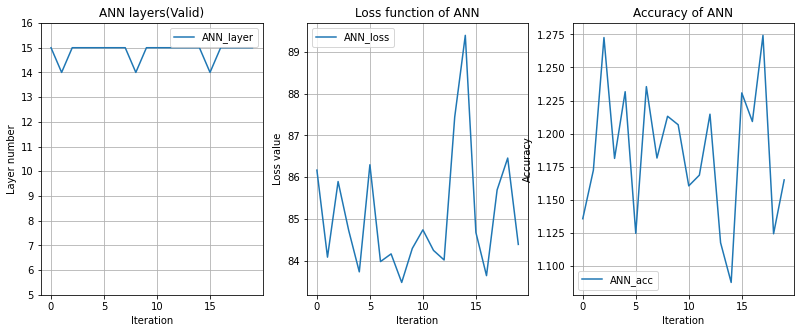

In [60]:
plt.figure(figsize=(13.5,5))
plt.subplot(1,3,1)
plt.grid()
plt.title("ANN layers(Valid)")
plt.plot(layer_record,label="ANN_layer")
plt.yticks(np.arange(5,17),np.arange(5,17))
plt.xlabel("Iteration")
plt.ylabel("Layer number")
plt.legend()
plt.subplot(1,3,2)
plt.grid()
plt.title("Loss function of ANN")
plt.plot(loss_record,label="ANN_loss")
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.legend()
plt.subplot(1,3,3)
plt.grid()
plt.title("Accuracy of ANN")
plt.plot(acc_record,label="ANN_acc")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("acc_loss_layernum.jpg")
plt.show()

In [73]:
np.save("loss_val.npy",np.array(loss_record))
np.save("acc_val.npy",np.array(acc_record))
np.save("layer_val.npy",np.array(layer_record))

In [74]:
actor.save_weights('acctor.h5')
critic.save_weights('critic.h5')

# Validation
## Using the well-trained Two-staged model on the valid dataset

In [55]:
def normalization(data):
    return (data-data.mean())/data.std()
(train_x,train_y),(test_x,test_y)=tf.keras.datasets.boston_housing.load_data()
train=normalization(train_x[:100]).astype("float32")
test=train_y[:100].astype("float32")
Val=normalization(test_x[:200]).astype("float32")
Val_test=test_y[:200].astype("float32")

In [56]:
try:
    actor = actor()
except:
    print("actor has been initialized")
e_greedy=0.8
layer_limit=15.
iteration=20
layer_init=15.
env = ENV(Val,Val_test, layer_init)
env.Train(60)
loss = env.learn()
In = np.array([[loss[0],layer_init*10]]).reshape(1,-1)
actor(In)
actor.load_weights('acctor.h5')
print("actor's weightens has been loaded")
F=layer_initializer()
F(train,1)
F.learn(1)
#iters,Input,real_label,layer_limit
F.Train(60,train,15.,15.)
layer_init=F(Val,15)[0][0]
loss_record=[]
acc_record=[]
layer_record=[]
env = ENV(Val,Val_test, layer_init)
env.Train(60)
loss = env.learn()
for j in range(iteration):
    print("Iteration:{} ready!".format(j+1))
    In = np.array([[loss[0],layer_init*10]]).reshape(1,-1)
    if np.random.randn() > e_greedy:
        action = np.random.choice([0, 1])
    else:
        actions = actor(In)
        action = np.argmax(actions)
    if action == 1:
        layer_next = layer_init + 1
    if action == 0:
        layer_next = layer_init - 1
    if layer_next > layer_limit:
        layer_next = layer_limit
    if layer_next<=0:
        layer_next=1
    env = ENV(Val,Val_test, layer_init)
    env.Train(60)
    next_loss=env.learn()
    layer_init = layer_next
    loss = next_loss
    loss_record.append(next_loss[0])
    acc_record.append(next_loss[1])
    layer_record.append(layer_init)

actor has been initialized
actor's weightens has been loaded
Iteration:1 ready!
Iteration:2 ready!
Iteration:3 ready!
Iteration:4 ready!
Iteration:5 ready!
Iteration:6 ready!
Iteration:7 ready!
Iteration:8 ready!
Iteration:9 ready!
Iteration:10 ready!
Iteration:11 ready!
Iteration:12 ready!
Iteration:13 ready!
Iteration:14 ready!
Iteration:15 ready!
Iteration:16 ready!
Iteration:17 ready!
Iteration:18 ready!
Iteration:19 ready!
Iteration:20 ready!


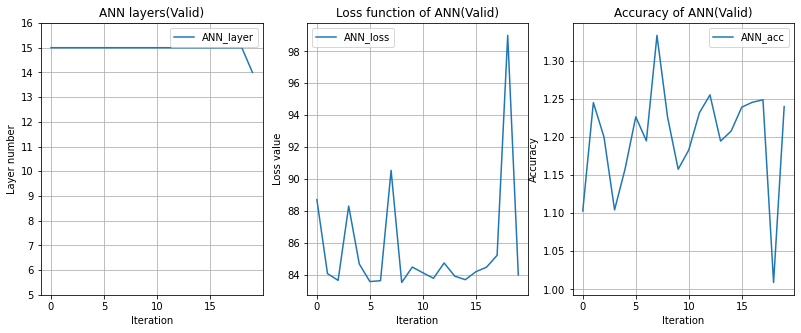

In [57]:
plt.figure(figsize=(13.5,5))
plt.subplot(1,3,1)
plt.grid()
plt.title("ANN layers(Valid)")
plt.plot(layer_record,label="ANN_layer")
plt.yticks(np.arange(5,17),np.arange(5,17))
plt.xlabel("Iteration")
plt.ylabel("Layer number")
plt.legend()
plt.subplot(1,3,2)
plt.grid()
plt.title("Loss function of ANN(Valid)")
plt.plot(loss_record,label="ANN_loss")
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.legend()
plt.subplot(1,3,3)
plt.grid()
plt.title("Accuracy of ANN(Valid)")
plt.plot(acc_record,label="ANN_acc")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("true_valid_acc_loss_layernum.jpg")
plt.show()